In [1]:
# STUDENT NAME: Zilong Wang
# STUDENT ID: 260823366
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

alpha = 1
beta = 0.0001
icd_desc = pd.read_csv('D_ICD_DIAGNOSES.csv.gz')
MIMIC3 = pd.read_csv('MIMIC3_DIAGNOSES_ICD_subset.csv.gz')

subjects = np.unique(MIMIC3['SUBJECT_ID'].values)
ICD9 = np.unique(MIMIC3['ICD9_CODE'].values)

# Count how many times each ICD code w appears in each patient d. 689 rows (patients) x 387 columns (ICD codes)
n_wd = pd.crosstab(MIMIC3["SUBJECT_ID"], MIMIC3["ICD9_CODE"])

# represent the ICD tokens in each patient as a long vector dictionary
long_vec = {}
for patient_d in subjects:
    
    # only use the ICD tokens that have a more than 0 counts
    all_tokens_patient_d = n_wd.loc[patient_d]
    existing_tokens_patient_d = all_tokens_patient_d[all_tokens_patient_d != 0]
    
    # expand the existing tokens into a long vector:
    long_vec_d = []
    for ICD in existing_tokens_patient_d.index:
        howmany = existing_tokens_patient_d[ICD]
        long_vec_d += [ICD] * howmany
    
    long_vec[patient_d] = long_vec_d

In [2]:
MIMIC3

,SUBJECT_ID,ICD9_CODE
0,17843,2851
1,10152,389
2,15311,4280
3,45434,5070
4,32229,51881
...,...,...
995,26042,5849
996,83875,486
997,50391,29410
998,25030,78039


In [2]:
# Q1 collapsed Gibbs sampling LDA
ntopics = 5

# first randomly initialize z_id
z_id = {}
for patient_d in subjects:
    z_id[patient_d] = np.random.randint(low=0, high=ntopics, size=len(long_vec[patient_d]))

    
def update_n_dotdk (z_id):
    n_dotdk = np.zeros((len(subjects), ntopics))
    for d, patient_d in enumerate(subjects):
        for icd_i, target_ICD in enumerate(long_vec[patient_d]):
            # here topic_k ranges from 0 to ntopics - 1
            topic_k = z_id[patient_d][icd_i]
            n_dotdk[d][topic_k] += 1
            
    return n_dotdk

def update_n_wdotk (z_id):
    n_wdotk = np.zeros((len(ICD9), ntopics))
    
    for d, patient_d in enumerate(subjects):
        for icd_i, target_ICD in enumerate(long_vec[patient_d]): 
            target_ICD_ind = np.where(ICD9 == target_ICD)[0][0]
            
            # here topic_k ranges from 1 to ntopics
            topic_k = z_id[patient_d][icd_i]
            
            # topic_k - 1 so that column index range from 0 to ntopics - 1
            n_wdotk[target_ICD_ind][topic_k] += 1 
    return n_wdotk

# initialize n_dotdk and n_wdotk according to random initial z_id
n_dotdk = update_n_dotdk (z_id)
n_wdotk = update_n_wdotk (z_id)

In [3]:
import copy

def resample_z_id (z_id):
    for d, patient_d in tqdm.tqdm(enumerate(subjects)):
        # a list of length i with each element bing the sampled topic assignment to ICD_i
        z_id_sample = []

        # each ICD i in patient d will have k possible topic assignments
        for icd_i, target_ICD in enumerate(long_vec[patient_d]):

            # a list of k values
            gamma_idk_list = []
            
            # figure out which topic (0 to ntopics - 1) was already assigned to position icd_i token in patient d,
            # then only that topic needs to be substracted. For example, if icd_i was assigned topic 1, and n_dotdk[d][0] == 1,
            # then n_dotdk_except_id[d][0] must be 1 - 1 = 0, whereas n_dotdk[d][1] == 1 is not affected by icd_i
            topic_already_assigned_icd_i = z_id[patient_d][icd_i]
            n_dotdk_except_id = copy.deepcopy(n_dotdk[d])
            n_dotdk_except_id[topic_already_assigned_icd_i] -= 1
            n_dotdk_except_id_alpha = n_dotdk_except_id + alpha
            
            # similarly, find out what x_id is, for example, x_id = 273, assigned to topics 1, 3, 4 across all patients,
            # but here z_id is assigned to 1
            # for n_xiddotk[273][0] == 1, then n_xiddotk_except_id[273][0] = 1 - 1 = 0, whereas n_xiddotk[273][2] == 1 is not affected
            x_id = np.where(ICD9 == target_ICD)[0][0]
            n_xiddotk_except_id = copy.deepcopy(n_wdotk[x_id])
            n_xiddotk_except_id[topic_already_assigned_icd_i] -= 1
            n_xiddotk_except_id_beta = n_xiddotk_except_id + beta
            
            # extend the above to all possible ICDs. For all the w != x_id, n_wdotk_except_id[w][0] = n_wdotk[w][0],
            # n_wdotk_except_id[w][1] = n_wdotk[w][1], etc. For w == x_id, n_wdotk_except_id will be the same as n_xiddotk_except_id
            # And we just need to sum first column-wise, and at topic_k - 1 position minus 1 to account for n_xiddotk_except_id
            denominator_pre_beta = n_wdotk + beta
            denominator_inter_beta = denominator_pre_beta.sum(axis=0)
            denominator_inter_beta[topic_already_assigned_icd_i] -= 1
            
            # now gamma_idk is a ntopics by 1 array
            gamma_idk = np.multiply(n_dotdk_except_id_alpha, np.divide(n_xiddotk_except_id_beta, denominator_inter_beta))
            
            # probability representation of gamma_idk
            prob_zid = gamma_idk / np.sum(gamma_idk)
            
           
            # now sample only 1 topic k for z_id according to prob_zid
            zid = np.random.choice(ntopics, p=prob_zid)
            z_id_sample.append(zid)
        
        # for patient d, update its resampled z_id
        z_id[patient_d] = np.array(z_id_sample)

In [4]:
# 100 iterations
for iteration in tqdm.tqdm(range(100)):
    resample_z_id (z_id)
    print(str(iteration) + ' iter resampling done')
    n_dotdk = update_n_dotdk (z_id)
    n_wdotk = update_n_wdotk (z_id)

  0%|                                                   | 0/100 [00:00<?, ?it/s]
689it [00:00, 7263.71it/s]
  1%|▍                                          | 1/100 [00:00<00:10,  9.71it/s]

0 iter resampling done



689it [00:00, 9030.86it/s]


1 iter resampling done



689it [00:00, 8841.38it/s]
  3%|█▎                                         | 3/100 [00:00<00:08, 11.15it/s]

2 iter resampling done



689it [00:00, 8295.92it/s]


3 iter resampling done



689it [00:00, 8998.05it/s]
  5%|██▏                                        | 5/100 [00:00<00:08, 11.28it/s]

4 iter resampling done



689it [00:00, 9218.87it/s]


5 iter resampling done



689it [00:00, 9077.84it/s]
  7%|███                                        | 7/100 [00:00<00:08, 11.60it/s]

6 iter resampling done



689it [00:00, 9129.34it/s]


7 iter resampling done



689it [00:00, 9335.64it/s]
  9%|███▊                                       | 9/100 [00:00<00:07, 11.81it/s]

8 iter resampling done



689it [00:00, 8567.75it/s]


9 iter resampling done



689it [00:00, 8867.99it/s]
 11%|████▌                                     | 11/100 [00:00<00:07, 11.70it/s]

10 iter resampling done



689it [00:00, 9055.91it/s]


11 iter resampling done



689it [00:00, 9164.66it/s]
 13%|█████▍                                    | 13/100 [00:01<00:07, 11.81it/s]

12 iter resampling done



689it [00:00, 9106.90it/s]


13 iter resampling done



689it [00:00, 8823.02it/s]
 15%|██████▎                                   | 15/100 [00:01<00:07, 11.83it/s]

14 iter resampling done



689it [00:00, 8526.27it/s]


15 iter resampling done



689it [00:00, 8999.50it/s]
 17%|███████▏                                  | 17/100 [00:01<00:07, 11.73it/s]

16 iter resampling done



689it [00:00, 9161.85it/s]


17 iter resampling done



689it [00:00, 9218.13it/s]
 19%|███████▉                                  | 19/100 [00:01<00:06, 11.83it/s]

18 iter resampling done



689it [00:00, 8483.14it/s]


19 iter resampling done



689it [00:00, 8817.29it/s]
 21%|████████▊                                 | 21/100 [00:01<00:06, 11.70it/s]

20 iter resampling done



689it [00:00, 8940.40it/s]


21 iter resampling done



689it [00:00, 9323.92it/s]
 23%|█████████▋                                | 23/100 [00:01<00:06, 11.79it/s]

22 iter resampling done



689it [00:00, 8731.72it/s]


23 iter resampling done



689it [00:00, 8391.09it/s]
 25%|██████████▌                               | 25/100 [00:02<00:06, 11.58it/s]

24 iter resampling done



689it [00:00, 8796.11it/s]


25 iter resampling done



689it [00:00, 9243.49it/s]
 27%|███████████▎                              | 27/100 [00:02<00:06, 11.67it/s]

26 iter resampling done



689it [00:00, 9081.58it/s]


27 iter resampling done



689it [00:00, 8910.68it/s]
 29%|████████████▏                             | 29/100 [00:02<00:06, 11.73it/s]

28 iter resampling done



689it [00:00, 7826.89it/s]


29 iter resampling done



689it [00:00, 9095.35it/s]
 31%|█████████████                             | 31/100 [00:02<00:05, 11.56it/s]

30 iter resampling done



689it [00:00, 8416.63it/s]


31 iter resampling done



689it [00:00, 8972.09it/s]
 33%|█████████████▊                            | 33/100 [00:02<00:05, 11.54it/s]

32 iter resampling done



689it [00:00, 9084.77it/s]


33 iter resampling done



689it [00:00, 9231.74it/s]
 35%|██████████████▋                           | 35/100 [00:03<00:05, 11.70it/s]

34 iter resampling done



689it [00:00, 8567.62it/s]


35 iter resampling done



689it [00:00, 8386.05it/s]
 37%|███████████████▌                          | 37/100 [00:03<00:05, 11.52it/s]

36 iter resampling done



689it [00:00, 9206.56it/s]


37 iter resampling done



689it [00:00, 8839.03it/s]
 39%|████████████████▍                         | 39/100 [00:03<00:05, 11.62it/s]

38 iter resampling done



689it [00:00, 8583.53it/s]


39 iter resampling done



689it [00:00, 8305.91it/s]
 41%|█████████████████▏                        | 41/100 [00:03<00:05, 11.47it/s]

40 iter resampling done



689it [00:00, 9019.64it/s]


41 iter resampling done



689it [00:00, 9172.72it/s]
 43%|██████████████████                        | 43/100 [00:03<00:04, 11.62it/s]

42 iter resampling done



689it [00:00, 8618.21it/s]


43 iter resampling done



689it [00:00, 7786.71it/s]
 45%|██████████████████▉                       | 45/100 [00:03<00:04, 11.36it/s]

44 iter resampling done



689it [00:00, 7029.09it/s]


45 iter resampling done



689it [00:00, 8114.76it/s]
 47%|███████████████████▋                      | 47/100 [00:04<00:04, 10.90it/s]

46 iter resampling done



689it [00:00, 7300.65it/s]


47 iter resampling done



689it [00:00, 8523.22it/s]
 49%|████████████████████▌                     | 49/100 [00:04<00:04, 10.76it/s]

48 iter resampling done



689it [00:00, 8595.42it/s]


49 iter resampling done



0it [00:00, ?it/s]
689it [00:00, 5753.66it/s]
 51%|█████████████████████▍                    | 51/100 [00:04<00:04, 10.24it/s]

50 iter resampling done



689it [00:00, 7780.99it/s]


51 iter resampling done



689it [00:00, 9231.94it/s]
 53%|██████████████████████▎                   | 53/100 [00:04<00:04, 10.50it/s]

52 iter resampling done



689it [00:00, 8920.72it/s]


53 iter resampling done



689it [00:00, 8459.67it/s]
 55%|███████████████████████                   | 55/100 [00:04<00:04, 10.77it/s]

54 iter resampling done



689it [00:00, 8867.45it/s]


55 iter resampling done



689it [00:00, 9283.22it/s]
 57%|███████████████████████▉                  | 57/100 [00:05<00:03, 11.11it/s]

56 iter resampling done



689it [00:00, 9095.95it/s]


57 iter resampling done



689it [00:00, 8614.00it/s]
 59%|████████████████████████▊                 | 59/100 [00:05<00:03, 11.27it/s]

58 iter resampling done



689it [00:00, 8503.56it/s]


59 iter resampling done



689it [00:00, 8792.26it/s]
 61%|█████████████████████████▌                | 61/100 [00:05<00:03, 11.32it/s]

60 iter resampling done



689it [00:00, 9146.80it/s]


61 iter resampling done



0it [00:00, ?it/s]
689it [00:00, 6302.66it/s]
 63%|██████████████████████████▍               | 63/100 [00:05<00:03, 10.63it/s]

62 iter resampling done



689it [00:00, 7753.77it/s]


63 iter resampling done



689it [00:00, 9283.73it/s]
 65%|███████████████████████████▎              | 65/100 [00:05<00:03, 10.79it/s]

64 iter resampling done



689it [00:00, 9366.87it/s]


65 iter resampling done



689it [00:00, 8543.58it/s]
 67%|████████████████████████████▏             | 67/100 [00:05<00:02, 11.03it/s]

66 iter resampling done



689it [00:00, 9684.60it/s]


67 iter resampling done



689it [00:00, 9579.27it/s]
 69%|████████████████████████████▉             | 69/100 [00:06<00:02, 11.46it/s]

68 iter resampling done



689it [00:00, 9294.36it/s]


69 iter resampling done



689it [00:00, 9724.49it/s]
 71%|█████████████████████████████▊            | 71/100 [00:06<00:02, 11.75it/s]

70 iter resampling done



689it [00:00, 9578.07it/s]


71 iter resampling done



689it [00:00, 9188.73it/s]
 73%|██████████████████████████████▋           | 73/100 [00:06<00:02, 11.91it/s]

72 iter resampling done



689it [00:00, 9076.30it/s]


73 iter resampling done



689it [00:00, 9638.67it/s]
 75%|███████████████████████████████▌          | 75/100 [00:06<00:02, 12.03it/s]

74 iter resampling done



689it [00:00, 9220.10it/s]


75 iter resampling done



689it [00:00, 8549.14it/s]
 77%|████████████████████████████████▎         | 77/100 [00:06<00:01, 11.91it/s]

76 iter resampling done



689it [00:00, 7871.04it/s]


77 iter resampling done



689it [00:00, 8860.16it/s]
 79%|█████████████████████████████████▏        | 79/100 [00:06<00:01, 11.62it/s]

78 iter resampling done



689it [00:00, 8422.79it/s]


79 iter resampling done



689it [00:00, 8503.59it/s]
 81%|██████████████████████████████████        | 81/100 [00:07<00:01, 11.49it/s]

80 iter resampling done



689it [00:00, 8293.30it/s]


81 iter resampling done



689it [00:00, 8457.72it/s]
 83%|██████████████████████████████████▊       | 83/100 [00:07<00:01, 11.37it/s]

82 iter resampling done



689it [00:00, 8514.79it/s]


83 iter resampling done



689it [00:00, 8407.67it/s]
 85%|███████████████████████████████████▋      | 85/100 [00:07<00:01, 11.31it/s]

84 iter resampling done



689it [00:00, 8413.94it/s]


85 iter resampling done



689it [00:00, 8620.14it/s]
 87%|████████████████████████████████████▌     | 87/100 [00:07<00:01, 11.30it/s]

86 iter resampling done



689it [00:00, 9158.10it/s]


87 iter resampling done



689it [00:00, 9288.59it/s]
 89%|█████████████████████████████████████▍    | 89/100 [00:07<00:00, 11.54it/s]

88 iter resampling done



689it [00:00, 8778.08it/s]


89 iter resampling done



689it [00:00, 8381.89it/s]
 91%|██████████████████████████████████████▏   | 91/100 [00:07<00:00, 11.48it/s]

90 iter resampling done



689it [00:00, 8400.17it/s]


91 iter resampling done



689it [00:00, 8426.67it/s]
 93%|███████████████████████████████████████   | 93/100 [00:08<00:00, 11.38it/s]

92 iter resampling done



689it [00:00, 7786.11it/s]


93 iter resampling done



0it [00:00, ?it/s]
689it [00:00, 6379.57it/s]
 95%|███████████████████████████████████████▉  | 95/100 [00:08<00:00, 10.41it/s]

94 iter resampling done



689it [00:00, 9121.94it/s]


95 iter resampling done



689it [00:00, 7965.43it/s]
 97%|████████████████████████████████████████▋ | 97/100 [00:08<00:00, 10.65it/s]

96 iter resampling done



689it [00:00, 7618.05it/s]


97 iter resampling done



689it [00:00, 9143.24it/s]
 99%|█████████████████████████████████████████▌| 99/100 [00:08<00:00, 10.76it/s]

98 iter resampling done



689it [00:00, 8710.48it/s]
100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.32it/s]

99 iter resampling done


In [5]:
# Normalize the final ICDs-by-topics and the patients-by-topics matrix

# for every element in n_wdotk, add beta
n_wdotk_beta = n_wdotk + beta

# the row-wise sum as the denominator, ntopics by 1
phi_wk_denominator = n_wdotk_beta.sum(axis=0)

# automatically broadcast to the w by k shape
phi_wk_expec = np.divide(n_wdotk_beta, phi_wk_denominator)

# store as a dataframe for easier access, index has to be instantiated one by one
ICD9_short_desc = [str(icd) + '-' + icd_desc.loc[icd_desc['ICD9_CODE']==str(icd)]['SHORT_TITLE'].values[0]
                   if str(icd) in icd_desc['ICD9_CODE'].values 
                   else str(icd) + '-' + 'N/A'
                   for icd in ICD9]

df_phi_wk_expec = pd.DataFrame(phi_wk_expec, index=ICD9)
df_phi_wk_expec['desc'] = ICD9_short_desc

# similarly for alpha and dk
n_dotdk_alpha = n_dotdk + alpha
theta_dk_denominator = n_dotdk_alpha.sum(axis=0)
theta_dk_expec = np.divide(n_dotdk_alpha, theta_dk_denominator)
df_theta_dk_expec = pd.DataFrame(theta_dk_expec, index=subjects)


In [6]:
phi_wk_expec

array([[4.80679797e-07, 5.12718758e-07, 4.83001487e-07, 5.07514514e-07,
        5.18082644e-03],
       [4.80679797e-07, 5.12718758e-07, 4.83001487e-07, 5.07514514e-07,
        5.18082644e-03],
       [4.80679797e-07, 5.12718758e-07, 4.83001487e-07, 1.52259429e-02,
        5.18030840e-07],
       ...,
       [4.80679797e-07, 5.12770030e-03, 4.83001487e-07, 5.07514514e-07,
        5.18030840e-07],
       [4.80679797e-07, 5.12718758e-07, 4.83001487e-07, 5.07565265e-03,
        5.18030840e-07],
       [4.80679797e-07, 5.12718758e-07, 4.83049787e-03, 5.07514514e-07,
        5.18030840e-07]])

In [6]:
# Q2 Visualizing the top ICD codes under each topic
import matplotlib.pyplot as plt
from seaborn import heatmap

# create an empty dataframe to store top 10 rows with repect to each topic
top_10_df = pd.DataFrame() 

for column in df_phi_wk_expec.columns[:ntopics]:

    # sort the dataframe by the current column in descending order and get the top 10 rows
    top_10 = df_phi_wk_expec.sort_values(by=column, ascending=False).head(10)

    # append the top 10 rows for the current column to the top_10_df dataframe
    top_10_df = top_10_df.append(top_10)



/var/folders/9b/7s2z8v0d0_gbpr40f5q16b500000gq/T/ipykernel_45234/4176847228.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_df = top_10_df.append(top_10)
/var/folders/9b/7s2z8v0d0_gbpr40f5q16b500000gq/T/ipykernel_45234/4176847228.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_df = top_10_df.append(top_10)
/var/folders/9b/7s2z8v0d0_gbpr40f5q16b500000gq/T/ipykernel_45234/4176847228.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_df = top_10_df.append(top_10)
/var/folders/9b/7s2z8v0d0_gbpr40f5q16b500000gq/T/ipykernel_45234/4176847228.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_df = top_1

<AxesSubplot: >

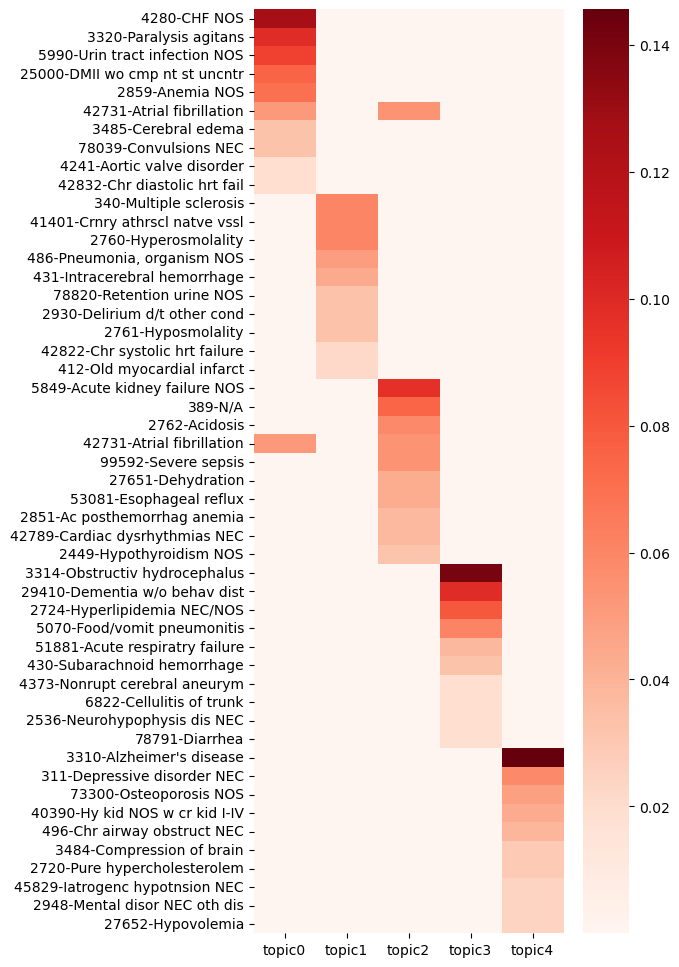

In [7]:
plt.figure(figsize=(5,12))
heatmap(top_10_df.loc[:, top_10_df.columns != 'desc'], cmap='Reds', square=False, xticklabels = ['topic' + str(i) for i in range(ntopics)], yticklabels = top_10_df['desc'].values)

In [8]:
# Q3 Correlating topics with the target ICD codes
from scipy import stats

str_long_vec = {}
for patient_d in subjects:
    str_long_vec[patient_d] = [str(icd) for icd in long_vec[patient_d]]

# binary coded representation of whether 331, 332, or 340 is the prefix of any of the N_d icd codes in each subjects.
ICD_331 = np.array([1 if any(icd.startswith('331') for icd in str_long_vec[patient_d]) else 0 for patient_d in subjects])
ICD_332 = np.array([1 if any(icd.startswith('332') for icd in str_long_vec[patient_d]) else 0 for patient_d in subjects])
ICD_340 = np.array([1 if any(icd.startswith('340') for icd in str_long_vec[patient_d]) else 0 for patient_d in subjects])

corr_matrix = np.zeros((ntopics, 3))

for topic_k in range(ntopics):
    corr_331 = stats.pearsonr(df_theta_dk_expec[topic_k].values, ICD_331)[0]
    corr_332 = stats.pearsonr(df_theta_dk_expec[topic_k].values, ICD_332)[0]
    corr_340 = stats.pearsonr(df_theta_dk_expec[topic_k].values, ICD_340)[0]
    corr_matrix[topic_k] = np.array([corr_331, corr_332, corr_340])

<AxesSubplot: >

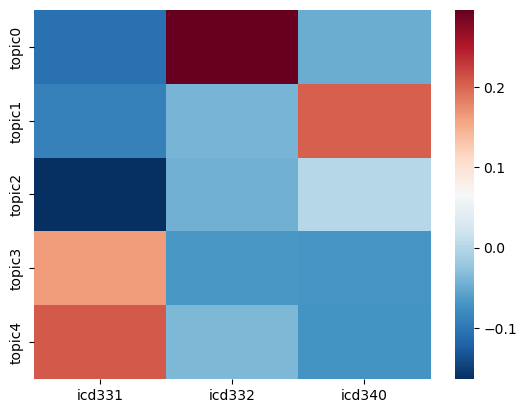

In [9]:
heatmap(corr_matrix, xticklabels=['icd331', 'icd332', 'icd340'], yticklabels = ['topic' + str(i) for i in range(ntopics)], cmap='RdBu_r')

In [10]:
# Q4 Visualizing patient topic mixtures
# create an empty dataframe to store top 100 subjects with repect to each topic
top_100_df = pd.DataFrame() 

for column in df_theta_dk_expec.columns:

    # sort the dataframe by the current column in descending order and get the top 100 rows
    top_100 = df_theta_dk_expec.sort_values(by=column, ascending=False).head(100)
    
    # append the top 10 rows for the current column to the top_100_df dataframe
    top_100_df = top_100_df.append(top_100)


# now the binary coded representation of whether 331, 332, or 340 is the prefix of 
# any of the N_d icd codes in top 100 subjects, with each containing 500 elements.
subjects_top_100 = top_100_df.index.values # the actual subjects codes 
subjects_top_100_ind = [np.where(subjects == subj)[0][0] for subj in subjects_top_100]

df_ICD = {'iccd331': ICD_331[subjects_top_100_ind], 'iccd332': ICD_332[subjects_top_100_ind], 
          'iccd340': ICD_340[subjects_top_100_ind]}

# ICD_331_top_100 = ICD_331[subjects_top_100_ind]
# ICD_332_top_100 = ICD_332[subjects_top_100_ind]
# ICD_340_top_100 = ICD_340[subjects_top_100_ind]

binary_df = pd.DataFrame(df_ICD)

# binary_df['iccd331'] = ICD_331_top_100
# binary_df['iccd332'] = ICD_332_top_100
# binary_df['iccd340'] = ICD_340_top_100

/var/folders/9b/7s2z8v0d0_gbpr40f5q16b500000gq/T/ipykernel_45234/4033428547.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_100_df = top_100_df.append(top_100)
/var/folders/9b/7s2z8v0d0_gbpr40f5q16b500000gq/T/ipykernel_45234/4033428547.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_100_df = top_100_df.append(top_100)
/var/folders/9b/7s2z8v0d0_gbpr40f5q16b500000gq/T/ipykernel_45234/4033428547.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_100_df = top_100_df.append(top_100)
/var/folders/9b/7s2z8v0d0_gbpr40f5q16b500000gq/T/ipykernel_45234/4033428547.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_100_

<AxesSubplot: >

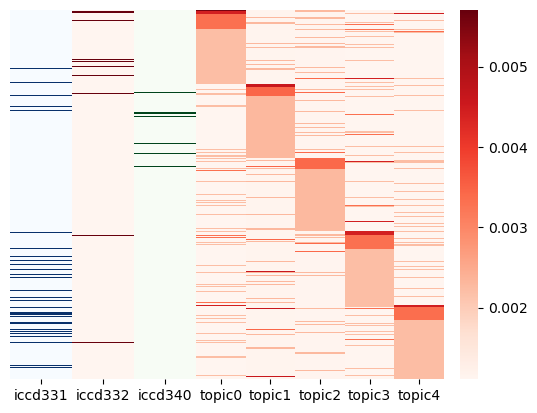

In [11]:
cm = ['Blues', 'Reds', 'Greens']
widths = [1,1,1,5]
f, axs = plt.subplots(1, binary_df.columns.size + 1, gridspec_kw={'wspace': 0, 'width_ratios': widths})
for i, (s, a, c) in enumerate(zip(binary_df.columns, axs, cm)):
    heatmap(np.array([binary_df[s].values]).T, yticklabels=False, xticklabels=[s], ax=a, cmap=c, cbar=False)
# heatmap(binary_df, cmap="hot", ax=ax1, cbar=False)
heatmap(top_100_df, cmap='Reds', ax=axs[-1], square=False, xticklabels = ['topic' + str(i) for i in range(ntopics)], yticklabels=False)
